## multiple roc, accuracy, try remove icd features, rerun using new features, try more loops with gradient boosting, feature importance using color map

In [7]:

import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
import operator

from sklearn.cross_validation import train_test_split
from random import shuffle
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer

%matplotlib inline

#PLOT CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import itertools

#matrix inverse
from numpy.linalg import inv

#default size of the graph
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', -1)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
def get_ml_data(dat, patid, test_size = 0.2, if_stimulated = 'all', if_itd = True, if_scaler = 0, if_remove_icd = 0):
    dat = dat.loc[dat.loc[:,'patid'] == patid]
    y = dat.loc[:,'label']
    drop_list = ['label', 'region_start_time', 'patid', 'epoch', 'if_stimulated']
    if if_remove_icd:
        drop_list.append('i12', 'i34')
    X = dat.drop(drop_list, axis = 1, inplace = False)
    
    y=y.astype('int')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify = y)
    scaler = preprocessing.StandardScaler().fit(X_train)
    if if_scaler:
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)    
    
        
    return X_train, X_test, y_train, y_test






In [9]:
def show_result(y_pred, df, clf_name = '', if_save = 0):
    heldout_scr = accuracy_score(y_test, y_pred)
    JJ.show_confusion_matrix(y_test, y_pred, clf_name, if_save)
    cols_to_keep = ['params', 'mean_test_score']
    df_toshow = df[cols_to_keep].fillna('-')
    df_toshow = pd.DataFrame(df_toshow.sort_values(by=["mean_test_score"],  ascending=False))
    display(pd.DataFrame(df_toshow))
    return df_toshow

In [10]:
import pickle
data = pickle.load( open( "../data/ml_ready_data.p", "rb" ) )

In [13]:

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
import jj_basic_fn as JJ
from sklearn import ensemble


# 1:svm.SVC, 2:svm.LinearSVC, 3:OneVsRestClassifier, 4:svm.SVC+probability=True
               # 5:GaussianNaiveBayes, 6:LogisticRegression, 7:LinearDiscriminantAnalysis
def parameter_tuning(X_train, X_test, y_train, y_test, classifier, C_range_num = 2, 
                     nfold = 10, if_save = 0):
    #defs is a dictionary to initiate classifier with the parameters that don't need to be tuned
    defs = {}
    defs['classifier'] = classifier
    
    num_instances, num_features = X_train.shape[0], X_train.shape[1]
    n_fold = 10

    skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
    CV = skf.split(np.zeros(len(y_train)), y_train)
    if classifier==1:
        clf_name = 'Logistic Regression'
        defs['class_weight'] = 'balanced'
        defs['max_iter'] = 200
        C_range = 10 ** np.random.uniform(-5, 1, size = C_range_num)
        tuned_params = dict(penalty=['l1','l2'], C=C_range)
    elif classifier == 2: 
        clf_name = 'SVM'
        defs['class_weight'] = 'balanced'
        kernel_list = ['rbf']    
        gamma_list = [2**i*1/num_features for i in range(1)]
        #degree_list = [2,3,4,5]
        C_range = 10 ** np.random.uniform(-2, 1, size = C_range_num)
        tuned_params = dict(kernel=kernel_list,gamma = gamma_list, C=C_range)

    elif classifier==3:
        clf_name = 'Gaussian Naive Bayes classifier'
        prr = np.ones(2) * (1.0/2)
        defs['priors'] = prr
        clf_try = JJ.clf_list(defs)
        clf_try.fit(X_train, y_train)
        JJ.save_object(clf_try, 'best_estimator_for_' + str(clf_name) + '.p')
        JJ.save_object(score, 'Best_score_for_' + str(clf_name) + '.p')
        return

    elif classifier==4:
        clf_name = 'Linear Discriminant Analysis'
        prr = np.ones(2) * (1.0/2)
        defs['solver'] = 'eigen'  # 'svd', 'lsqr', 'eigen'
        defs['shrinkage'] = 'auto'
        defs['priors'] = prr
        clf_try = JJ.clf_list(defs)
        clf_try.fit(X_train, y_train)
        JJ.save_object(clf_try, 'best_estimator_for_' + str(clf_name) + '.p')
        return
    elif classifier == 5:
        clf_name = 'decision tree'
        mss_list = [5,10,20,40,60]
        criterion_list = ['entropy']
        max_depth_list = [3,4,5,8,12,18]
        clf_name = 'decision tree'
        tuned_params = dict(criterion=criterion_list, min_samples_split=mss_list, max_depth = max_depth_list)
    elif classifier == 6:
        clf_name = 'random forest'
        defs['n_estimators'] = 200
        mss_list = [25,30,40]
        criterion_list = ['entropy']
        max_depth_list = [10,11,12,13,14]
        max_features_list = ['auto']
        tuned_params = dict(criterion=criterion_list, min_samples_split=mss_list, max_depth = max_depth_list, max_features = max_features_list)
    elif classifier == 7:
        clf_name = 'gradient boosting'
        defs['n_estimators'] = 1200
        max_depth_list, subsample_list, learning_rate_list, min_samples_leaf_list = [2,3,4,5], [0.2,0.3,0.5], [0.01,0.001], [5,10,20] 
        #params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
        #  'learning_rate': 0.01, 'min_samples_leaf': 10, 'random_state': 3}
        tuned_params = dict(max_depth=max_depth_list, subsample = subsample_list,learning_rate = learning_rate_list, min_samples_leaf= min_samples_leaf_list)
    
        
    clf_try = JJ.clf_list(defs)
    
    clf_grid = GridSearchCV(clf_try,
                            param_grid=tuned_params,
                            cv=CV,
                            scoring = 'roc_auc',
                            verbose=1,
                           return_train_score = True)
    clf_grid.fit(X_train, y_train)
    print('Best score: {}'.format(clf_grid.best_score_))
    print('Best parameters: {}'.format(clf_grid.best_params_))

    clf_best = clf_grid.best_estimator_

    y_pred = clf_best.predict(X_test)
    df = pd.DataFrame(clf_grid.cv_results_)
    show_result(y_pred, df, clf_name, if_save = if_save)
        
    if if_save:
        JJ.save_object(df, 'result_df_for_' + str(clf_name) + '.p')
        JJ.save_object(clf_best, 'best_estimator_for_' + str(clf_name) + '.p')
        JJ.save_object(clf_grid.best_score_, 'Best_score_for_' + str(clf_name) + '.p')
        JJ.save_object(clf_grid.best_params_, 'best_params_for_' + str(clf_name) + '.p')




In [ ]:
def parameter_tuning_all(X_train, X_test, y_train, y_test, if_save = 1):
    

In [14]:
X_train, X_test, y_train, y_test = get_ml_data(data, '231', if_scaler = 1)
parameter_tuning(X_train, X_test, y_train, y_test, classifier = 7, if_save = 1)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


KeyboardInterrupt: 

In [167]:
#logistic regression
X_train, X_test, y_train, y_test = get_ml_data(data, '231', if_scaler = 1)
parameter_tuning(X_train, X_test, y_train, y_test, classifier = 4, C_range_num = 30, if_save = 1)


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    7.9s finished


Best score: 0.8228937728937729
Best parameters: {'C': 7.9017616277704512, 'kernel': 'rbf', 'gamma': 0.03333333333333333}
Confusion matrix, without normalization


,params,mean_test_score
15,"{'C': 7.92755964088, 'kernel': 'rbf', 'gamma': 0.03333333333333333}",0.822894
7,"{'C': 7.90176162777, 'kernel': 'rbf', 'gamma': 0.03333333333333333}",0.822894
8,"{'C': 6.73777666694, 'kernel': 'rbf', 'gamma': 0.03333333333333333}",0.821062
27,"{'C': 1.37649557674, 'kernel': 'rbf', 'gamma': 0.03333333333333333}",0.815293
21,"{'C': 0.887801644454, 'kernel': 'rbf', 'gamma': 0.03333333333333333}",0.815293
19,"{'C': 4.16592442146, 'kernel': 'rbf', 'gamma': 0.03333333333333333}",0.815201
24,"{'C': 2.16823200502, 'kernel': 'rbf', 'gamma': 0.03333333333333333}",0.815110
12,"{'C': 0.597316640675, 'kernel': 'rbf', 'gamma': 0.03333333333333333}",0.815110
28,"{'C': 1.56469238811, 'kernel': 'rbf', 'gamma': 0.03333333333333333}",0.815018
9,"{'C': 0.762916748001, 'kernel': 'rbf', 'gamma': 0.03333333333333333}",0.815018


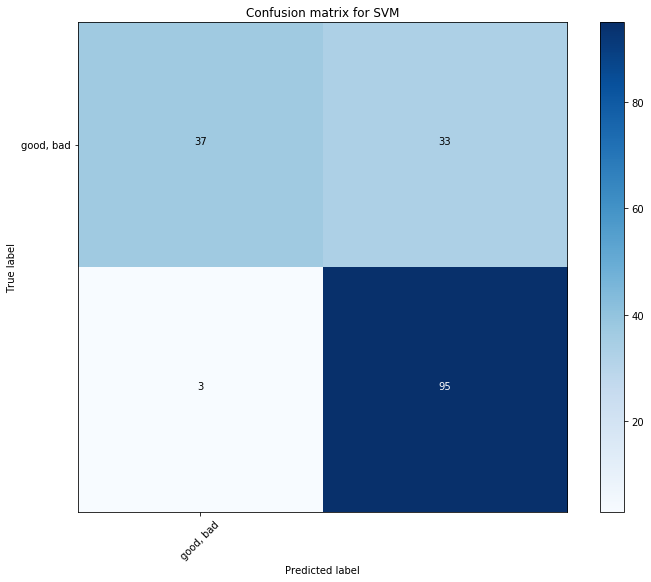

In [68]:

X_train, X_test, y_train, y_test = get_ml_data(data, '231', if_scaler = 1)
parameter_tuning(X_train, X_test, y_train, y_test, classifier = 2, C_range_num = 30, if_save = 1)


In [15]:
def estimator_performance(classifier_int, if_plot_c = 1, if_plot_roc = 1):
    int2name = {1:'Logistic Regression', 2: 'SVM', 3: 'Gaussian Naive Bayes classifier', 4:'Linear Discriminant Analysis', 5:'decision tree', 6:'random forest', 7:'gradient boosting'}
    clf_name = int2name[classifier_int]
    clf = pickle.load(open('best_estimator_for_' + str(clf_name) + '.p', "rb" ))
    score = pickle.load(open('Best_score_for_' + str(clf_name) + '.p', "rb" ))
    y_pred = clf.predict(X_test)
    accuracy = clf.score(X_test, y_test)
    if classifier_int == 3 or classifier_int == 5 or classifier_int == 6:
        y_prob = clf.predict_proba(X_test)[:,1]
        y_prob = [prob + 0.001 * (prob < 0.001) - 0.001 * (1 - prob < 0.001) for prob in y_prob]
        y_score = np.array([-np.log(1/prob - 1) for prob in y_prob])
    else:
        y_score = clf.decision_function(X_test)
    if if_plot_c:
        JJ.show_confusion_matrix(y_test, y_pred, clf_name)
    if if_plot_roc:
        JJ.plot_roc(y_score, y_test)
    return score, accuracy

In [28]:
def scores_estimators():
    int2name = {1:'Logistic Regression', 2: 'SVM', 3: 'Gaussian Naive Bayes classifier', 4:'Linear Discriminant Analysis', 5:'decision tree', 6:'random forest', 7:'gradient boosting'}
    n_estimator = 7
    auc_dict = {}
    acc_dict = {}
    estimators = [1,2,5,6,7]
    for i in estimators:
        auc, accuracy = estimator_performance(i, if_plot_c = 0, if_plot_roc = 0)
        name = int2name[i]
        auc_dict[name] = auc
        acc_dict[name] = accuracy
    sorted_auc_dict = sorted(auc_dict.items(), key=operator.itemgetter(1), reverse=True)
    sorted_acc_dict = sorted(acc_dict.items(), key=operator.itemgetter(1), reverse=True)
    display(pd.DataFrame(sorted_auc_dict, columns = ['Classifier', 'AUC']))
    display(pd.DataFrame(sorted_acc_dict, columns = ['Classifier', 'Accuracy']))

In [29]:
scores_estimators()

,classifier,AUC
0,gradient boosting,0.861905
1,random forest,0.851832
2,decision tree,0.839927
3,SVM,0.822894
4,Logistic Regression,0.821612


,classifier,Accuracy
0,gradient boosting,0.809524
1,random forest,0.785714
2,SVM,0.785714
3,decision tree,0.779762
4,Logistic Regression,0.773810


0.809523809524
Confusion matrix, without normalization


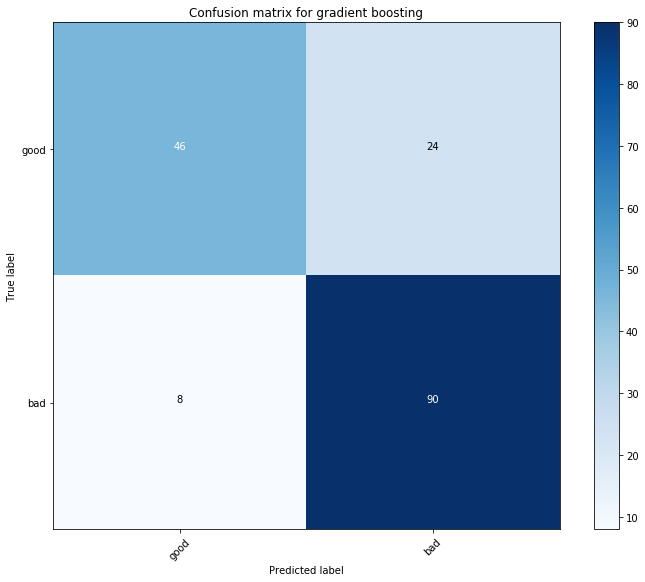

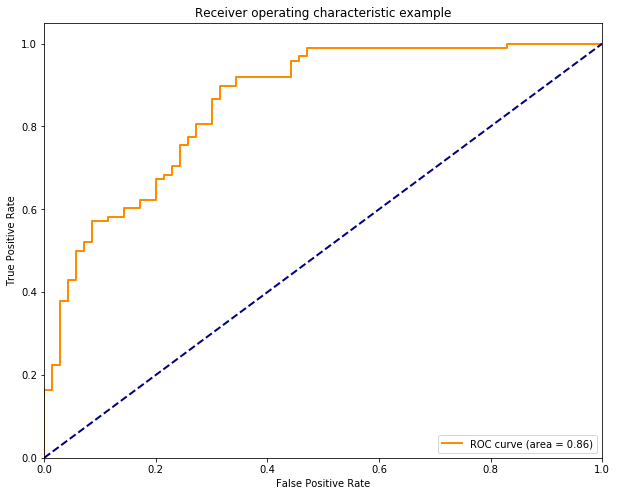

0.86190476190476206

In [240]:
estimator_performance(7)